Optimal Coal Flow: 692.18 kg/h
Optimal Air Flow: 491.95 kg/h
Optimal Steam Temperature: 499.99 °C
Optimal Spray Flow: 0.00 kg/h


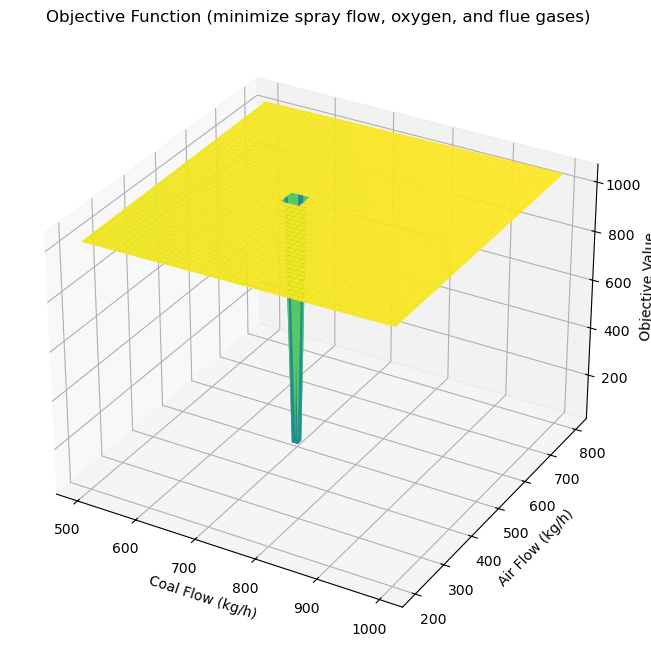

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Constants and parameters
spray_factor = 10
delta = 0.1
epsilon = 0.05
zeta = 0.02
eta = 0.03
theta = 0.04

# Model Functions
def efficiency_model(coal_flow, air_flow, spray_flow):
    # Simplified efficiency model (in percentage)
    return 90 - 0.05 * (coal_flow - 700)**2 - 0.03 * (air_flow - 500)**2 - 0.1 * (spray_flow)

def spray_flow_model(steam_temp):
    # Spray flow only if temperature exceeds 500°C
    return max(0, steam_temp - 500) * spray_factor

def oxygen_consumption_model(coal_flow, air_flow):
    return delta * coal_flow + epsilon * air_flow

def flue_gases_model(coal_flow, air_flow, spray_flow):
    return zeta * coal_flow + eta * air_flow + theta * spray_flow

# Objective Function (to minimize)
def objective(params):
    coal_flow, air_flow, steam_temp = params
    # Calculate spray flow if temperature exceeds 500°C
    spray_flow = spray_flow_model(steam_temp)
    # Calculate the efficiency, oxygen consumption, and flue gases
    efficiency = efficiency_model(coal_flow, air_flow, spray_flow)
    oxygen = oxygen_consumption_model(coal_flow, air_flow)
    flue_gases = flue_gases_model(coal_flow, air_flow, spray_flow)
    
    # Objective is to minimize spray flow, oxygen, and flue gases
    objective_value = 0.5 * spray_flow + 0.3 * oxygen + 0.2 * flue_gases
    
    # Add a penalty for low efficiency to ensure it's above the threshold
    if efficiency < 85:
        objective_value += 1000  # High penalty for low efficiency
    
    return objective_value

# Constraints: Efficiency and Steam Temperature
def efficiency_constraint(params):
    coal_flow, air_flow, steam_temp = params
    spray_flow = spray_flow_model(steam_temp)
    efficiency = efficiency_model(coal_flow, air_flow, spray_flow)
    return efficiency - 85  # Should be >= 85%

def temperature_constraint(params):
    steam_temp = params[2]
    return 550 - steam_temp  # Should be <= 550°C

# Bounds for variables
bounds = [(500, 1000),  # Coal flow range
          (200, 800),  # Air flow range
          (400, 550)]  # Steam temperature range (for safe operation)

# Initial guess
x0 = [700, 500, 500]  # Starting values for coal flow, air flow, steam temperature

# Constraints dictionary
constraints = [{'type': 'ineq', 'fun': efficiency_constraint},
               {'type': 'ineq', 'fun': temperature_constraint}]

# Optimization
result = minimize(objective, x0, bounds=bounds, constraints=constraints, method='SLSQP')

# Optimal results
optimal_coal_flow, optimal_air_flow, optimal_steam_temp = result.x
optimal_spray_flow = spray_flow_model(optimal_steam_temp)

print(f"Optimal Coal Flow: {optimal_coal_flow:.2f} kg/h")
print(f"Optimal Air Flow: {optimal_air_flow:.2f} kg/h")
print(f"Optimal Steam Temperature: {optimal_steam_temp:.2f} °C")
print(f"Optimal Spray Flow: {optimal_spray_flow:.2f} kg/h")

# Plotting the results
# Create a 3D plot for the optimization results
coal_flow_vals = np.linspace(500, 1000, 50)
air_flow_vals = np.linspace(200, 800, 50)
coal_flow_grid, air_flow_grid = np.meshgrid(coal_flow_vals, air_flow_vals)
objective_vals = np.array([objective([cf, af, optimal_steam_temp]) for cf, af in zip(coal_flow_grid.flatten(), air_flow_grid.flatten())])
objective_vals = objective_vals.reshape(coal_flow_grid.shape)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(coal_flow_grid, air_flow_grid, objective_vals, cmap='viridis')
ax.set_title("Objective Function (minimize spray flow, oxygen, and flue gases)")
ax.set_xlabel("Coal Flow (kg/h)")
ax.set_ylabel("Air Flow (kg/h)")
ax.set_zlabel("Objective Value")

plt.show()
